# 模型选择、欠拟合和过拟合

通过多项式拟合来探索这些概念

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

使用以下三阶多项式来生成训练和测试数据的标签：
$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2)$$

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

查看一下前2个样本

In [4]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.7408],
         [ 0.9021]]),
 tensor([[ 1.0000e+00, -7.4078e-01,  2.7438e-01, -6.7751e-02,  1.2547e-02,
          -1.8589e-03,  2.2951e-04, -2.4288e-05,  2.2490e-06, -1.8511e-07,
           1.3713e-08, -9.2346e-10,  5.7007e-11, -3.2484e-12,  1.7188e-13,
          -8.4884e-15,  3.9300e-16, -1.7125e-17,  7.0478e-19, -2.7478e-20],
         [ 1.0000e+00,  9.0208e-01,  4.0687e-01,  1.2234e-01,  2.7591e-02,
           4.9777e-03,  7.4838e-04,  9.6443e-05,  1.0875e-05,  1.0900e-06,
           9.8325e-08,  8.0633e-09,  6.0614e-10,  4.2061e-11,  2.7101e-12,
           1.6298e-13,  9.1889e-15,  4.8759e-16,  2.4436e-17,  1.1602e-18]]),
 tensor([2.9074, 5.2200]))

实现一个函数来评估模型在给定数据集上的损失

In [5]:
def evaluate_loss(net, data_iter, loss):  
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

定义训练函数

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

三阶多项式函数拟合(正常)

weight: [[ 5.000446   1.1925726 -3.3994446  5.613429 ]]


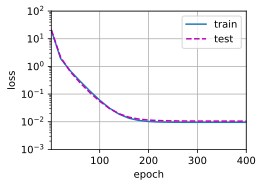

In [7]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

线性函数拟合(欠拟合)

weight: [[3.3861537 3.623168 ]]


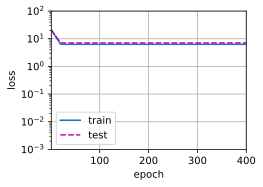

In [8]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

高阶多项式函数拟合(过拟合)

weight: [[ 4.976002    1.2835668  -3.2593832   5.150967   -0.41944516  1.348935
  -0.17952554  0.15169154 -0.15447472  0.15434313  0.11540707 -0.20328848
   0.20229222 -0.19785015 -0.13074256 -0.16738276  0.03405237 -0.03323355
  -0.08506632  0.14969553]]


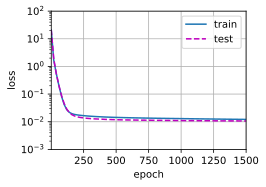

In [9]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)